In [ ]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [2]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [3]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [4]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [5]:
wiki.invoke("Attention is all you need")

'Page: Attention Is All You Need\nSummary: "Attention Is All You Need" is a 2017 landmark research paper in machine learning authored by eight scientists working at Google. The paper introduced a new deep learning architecture known as the transformer, based on the attention mechanism proposed in 2014 by Bahdanau et al. It is considered a foundational paper in modern artificial intelligence, and a main contributor to the AI boom, as the transformer approach has become the main architecture of a wi'

In [6]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")



In [7]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

tavily.invoke("Provide me the recent AI news")

C:\Users\asus\AppData\Local\Temp\ipykernel_24100\1678487253.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


[{'title': 'AI News | Latest AI News, Analysis & Events',
  'url': 'https://www.artificialintelligence-news.com/',
  'content': 'UK and Singapore form alliance to guide AI in finance · July 4, 2025 ; Study finds AI can slash global carbon emissions · July 2, 2025 ; Anthropic tests AI running',
  'score': 0.72559077},
 {'title': 'The latest AI news we announced in June - Google Blog',
  'url': 'https://blog.google/technology/ai/google-ai-updates-june-2025/',
  'content': '# The latest AI news we announced in June\n\nJul 02, 2025\n\nHere’s a recap of some of our biggest AI updates from June, including more ways to search with AI Mode, a new way to share your NotebookLM notebooks publicly, and a new AI to help researchers better understand the human genome.\n\nSuperG\n\n## Basic explainer [...] For more than 20 years, we’ve invested in machine learning and AI research, tools and infrastructure to build products that make everyday life better for more people. Teams across Google are workin

In [8]:
###Combine all the tools in the list

tools = [arxiv, wiki, tavily]


In [9]:
from langchain_groq import ChatGroq

model = ChatGroq(model = "qwen/qwen3-32b")
model_with_tools = model.bind_tools(tools)

In [11]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
model_with_tools.invoke([HumanMessage(content=f"What is the recent AI news")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent AI news. Let me see which tool I can use here. The available tools are arxiv, wikipedia, and tavily_search_results_json. \n\nArxiv is good for academic papers, but the user might be looking for more general news. Wikipedia is for encyclopedic information, which might not be the latest. Tavily_search_results_json sounds like a search engine that can fetch recent news articles. \n\nSo, I should use tavily_search_results_json with the query "recent AI news" to get the latest updates. That should provide the user with the most current information available.\n', 'tool_calls': [{'id': 'z62d3fshw', 'function': {'arguments': '{"query":"recent AI news"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 159, 'prompt_tokens': 266, 'total_tokens': 425, 'completion_time': 0.250866692, 'prompt_time': 0.016412936, 'queue_time': 0.2018

In [12]:
model_with_tools.invoke([HumanMessage(content=f"What is the recent AI news")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': '3e1ajydac',
  'type': 'tool_call'}]

In [13]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list[AnyMessage], add_messages]

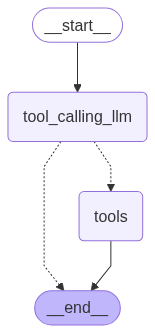

In [14]:
###Entire chatbot with LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

def tool_calling_llm(state:State):
    return {"messages":[model_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    #if the lastest message(result) from assistant is a tool call -> tools_condition routes to tools
    #if the latest message(result) from assistant is not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
messages = graph.invoke({"messages":HumanMessage(content="Provide me the top 10 AI news about context engineering")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 AI news about context engineering
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (w72k71n0v)
 Call ID: w72k71n0v
  Args:
    query: top 10 AI news on context engineering
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Context Engineering: Elevating AI Strategy from Prompt Crafting to ...", "url": "https://medium.com/@adnanmasood/context-engineering-elevating-ai-strategy-from-prompt-crafting-to-enterprise-competence-b036d3f7f76f", "content": "“Stop Prompting, Start Engineering: 15 Principles to Deliver Your AI Agent to Production,” _HackerNoon_, [Online]. Available: \n\n “Understanding the Emergence of Context Engineering in AI Systems,” _blockchain.news_, [Online]. Available: \n\n A. Karpathy, “Andrej Karpathy — X,” _X.com_, [Online